In [3]:
import numpy as np
import msprime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import resample
from statistics import mean, stdev
from math import sqrt
import seaborn as sns
import allel
from scipy.stats import norm


In [47]:
pop_ind = 100
split_times = {
    'AB' : 50,
    'ABC' : 100,
    'ABCD' : 150,
}


demography = msprime.Demography()
demography.add_population(name="A", initial_size=pop_ind)
demography.add_population(name="B", initial_size=pop_ind)
demography.add_population(name="C", initial_size=pop_ind)
demography.add_population(name="D", initial_size=pop_ind)

demography.add_population(name="AB", initial_size=pop_ind)
demography.add_population(name="ABC", initial_size=pop_ind)
demography.add_population(name="ABCD", initial_size=pop_ind)

demography.add_population_split(time=split_times['AB'],
                                derived=["A", "B"], ancestral="AB")
demography.add_population_split(time=split_times['ABC'],
                                derived=["AB", "C"], ancestral="ABC")
demography.add_population_split(time=split_times['ABCD'],
                                derived=["ABC", "D"], ancestral="ABCD")

PopulationSplit(time=150, derived=['ABC', 'D'], ancestral='ABCD')

In [48]:
seq_len = 1e9
rec_rate = 1e-8
mut_rate = 1e-8

In [49]:
ts = msprime.sim_ancestry(
    samples={'A': pop_ind, 'B': pop_ind, 'C': pop_ind, 'D': pop_ind},  # diploid samples
    demography=demography,
    ploidy=2,
    sequence_length=seq_len,
    discrete_genome=False,
    recombination_rate=rec_rate,
    model='dtwf',
    random_seed=None
)

ts = msprime.sim_mutations(
    ts,
    rate=mut_rate,
    discrete_genome=False,
    #start_time=split_time,
    random_seed=None
    )
ts

In [50]:
ts.f4(sample_sets = [list(ts.samples(x)) for x in range(4) ], mode = 'site', span_normalise=False)

array(-11.8263)

In [59]:
# now with migration
pop_ind = 500
split_times = {
    'AB' : 500,
    'ABC' : 1000,
    'ABCD' : 1500,
}


demography = msprime.Demography()
demography.add_population(name="A", initial_size=pop_ind)
demography.add_population(name="B", initial_size=pop_ind)
demography.add_population(name="C", initial_size=pop_ind)
demography.add_population(name="D", initial_size=pop_ind)

demography.add_population(name="AB", initial_size=pop_ind)
demography.add_population(name="ABC", initial_size=pop_ind)
demography.add_population(name="ABCD", initial_size=pop_ind)

demography.add_population_split(time=split_times['AB'],
                                derived=["A", "B"], ancestral="AB")
demography.add_population_split(time=split_times['ABC'],
                                derived=["AB", "C"], ancestral="ABC")
demography.add_population_split(time=split_times['ABCD'],
                                derived=["ABC", "D"], ancestral="ABCD")
demography.add_mass_migration(time = 30, source='A', dest='C', proportion=.1)
demography.sort_events()

In [60]:
ts = msprime.sim_ancestry(
    samples={'A': pop_ind, 'B': pop_ind, 'C': pop_ind, 'D': pop_ind},  # diploid samples
    demography=demography,
    ploidy=2,
    sequence_length=seq_len,
    discrete_genome=False,
    recombination_rate=rec_rate,
    model='dtwf',
    random_seed=None
)

ts = msprime.sim_mutations(
    ts,
    rate=mut_rate,
    discrete_genome=False,
    #start_time=split_time,
    random_seed=None
    )
ts

In [62]:
ts.f4(sample_sets = [list(ts.samples(x)) for x in range(4) ], mode = 'site', span_normalise=True)

array(1.06701846e-06)

In [66]:
ts.f4(sample_sets = [list(ts.samples(x)) for x in range(4) ], mode = 'site', windows = 'sites', span_normalise=False)

array([ 0.      ,  0.      ,  0.      , ..., -0.039032,  0.      ,
        0.      ])

In [67]:
f4 = ts.f4(sample_sets = [list(ts.samples(x)) for x in range(4) ], mode = 'site', windows = 'sites', span_normalise=False)

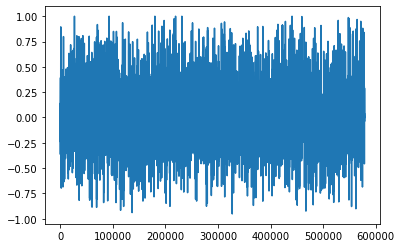

In [68]:
plt.plot(f4)

In [2]:
def sim(pop_ind, split_time, seq_len, rec_rate, mut_rate, ancestral_size=None, seed=None):
    """simulate two populations that have diverged from a common ancestral population.
    Returns a tree sequence.
    pop_ind -- number of sample individuals for each population,
        which at the default ploidy of two will give us eight sample nodes for two population
    split_time -- current populations split from the
        ancestral population this many generations ago
    seq_len -- length of the genome, units ~ base-pairs
    rec_rate -- recombination rate, units = rate per bp, per generation
    mut_rate -- mutation rate, units = rate per bp, per generation
    """
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=pop_ind)
    demography.add_population(name="B", initial_size=pop_ind)
    if ancestral_size:
        demography.add_population(name="C", initial_size=ancestral_size)
    else:
        demography.add_population(name="C", initial_size=pop_ind)
    demography.add_population_split(time=split_time,
                                    derived=["A", "B"], ancestral="C")

    ts = msprime.sim_ancestry(
        samples={'A': pop_ind, 'B': pop_ind},  # diploid samples
        demography=demography,
        ploidy=2,
        sequence_length=seq_len,
        discrete_genome=False,
        recombination_rate=rec_rate,
        model='dtwf',
        random_seed=seed
    )

    ts = msprime.sim_mutations(
        ts,
        rate=mut_rate,
        discrete_genome=False,
        start_time=split_time,
        random_seed=seed
        )

    return ts

In [3]:
def sample_individuals(haploid_indexes, n, replace, seed=None):
    """
    return the (haploid) indexes that correspond to
    taking n diploid samples from the supplied haploid indexes
    haploid_indexes -- contiguous indexes for haploids
        should be from a single population.
    n -- the number of diploid individuals to take.
    """

    # ensure the haploid indexes are consecutive
    # diff = np.diff(haploid_indexes)
    # assert np.sum(diff == 1) == (len(haploid_indexes)-1)

    ind_indexes = haploid_indexes[::2]
    np.random.seed(seed)
    ind_samples = np.sort(np.random.choice(ind_indexes, n, replace=replace))
    haploid_samples = np.zeros(n * 2, dtype='int')
    haploid_samples[0::2] = ind_samples
    haploid_samples[1::2] = ind_samples+1
    return haploid_samples

In [67]:
def strip_MAC(ts, MAC):
	"""
	Removes sites with minor allele count >= MAC.
	Returns a new tree-sequence with sites removed
	"""

	initial_sites = ts.num_sites
	sites_to_remove = []
	for tree in ts.trees(tracked_samples=present_samples):
		for site in tree.sites():
			assert len(site.mutations) == 1  # Only supports infinite sites muts.
			mut = site.mutations[0]
			if (tree.num_tracked_samples(mut.node) <= MAC) or \
				(tree.num_tracked_samples(mut.node) >= (npresent_samples - MAC)):
				sites_to_remove.append(site.id)

	ts = ts.delete_sites(sites_to_remove)
	final_sites = ts.num_sites
	print("MAC filter:")
	print(f"removed {initial_sites-final_sites} sites ({(initial_sites-final_sites)/(initial_sites):.0%}), {final_sites} sites remain")
	return ts

In [4]:
def observe(ts, num_ind, max_sites, num_pop, seed=None):
    """Observe num_ind from each population
    simplify the ts, removing non-variable sites across those individuals.
    Return a tree sequence
    ts -- data (a tree sequence) to be sampled
    num_ind -- number of individual to sample from each population
    max_sites -- retain at most max_sites, from among variable sites
    num_pop -- number of population
    """
    # index of sample node for each population
    sample_nodes = [ts.samples(population=i) for i in range(num_pop)]
    # randomly select num_ind sample nodes
    all_ind = np.concatenate([sample_individuals(i, num_ind, replace=False, seed=seed)
                              for i in sample_nodes])
    obs_ts = ts.simplify(samples=all_ind, filter_sites=False)

    if obs_ts.num_sites > max_sites:
        all_sites = np.arange(len(obs_ts.sites()))
        np.random.seed(seed)
        sites_keep = np.random.choice(all_sites, max_sites, replace=False)
        sites_remove = np.setdiff1d(all_sites, sites_keep)
        obs_ts = obs_ts.delete_sites(sites_remove)

    return obs_ts

In [5]:
def jk_split(n_block, to_split, seed):
    """split sites/samples into blocks with unequal sizes
    n_block -- number of blocks
    to_split -- numpy array to split (self.sites_index or self.samples_index)
    """
    np.random.seed(seed)
    random = np.random.multinomial(
        n=len(to_split) - n_block,
        pvals=np.ones(n_block) / n_block,
    ) + 1

    # index of sites in each block
    indices = np.split(to_split, np.cumsum(random))[0: n_block]
    # number of sites in each fold
    sizes = list(map(len, indices))
    return indices, np.array(sizes)


def generate_samples_index(individuals):
    """return samples_index for the input ind_index
    because of diploid, individual 1 has sample index (2, 3)
    @individuals: a list of individuals index
    """
    res = np.zeros(len(individuals) * 2, dtype=int)
    for i, index in enumerate(individuals):
        res[i * 2] = index * 2
        res[i * 2 + 1] = index * 2 + 1

    return res

In [6]:
def get_fst(dA, dB, dAB):
    mean_within = (dA + dB) / 2
    between = dAB 
    Fst = 1 - mean_within.sum() / between.sum()
    return Fst

In [7]:
def jk_split(n_block, to_split, seed=None):
    """split sites/samples into blocks with unequal sizes
    n_block -- number of blocks
    to_split -- numpy array to split (self.sites_index or self.samples_index)
    """
    if seed:
        np.random.seed(seed)
    random = np.random.multinomial(
        n=len(to_split) - n_block,
        pvals=np.ones(n_block) / n_block,
    ) + 1

    # index of sites in each block
    indices = np.split(to_split, np.cumsum(random))[0: n_block]
    # number of sites in each fold
    sizes = list(map(len, indices))
    return indices, np.array(sizes)


In [8]:
def get_blocked_fst(dA, dB, dAB):
    # convert vals of each block to vals leaving each block out
    dA=dA.sum()-dA
    dB=dB.sum()-dB
    dAB=dAB.sum()-dAB
    
    mean_within = (dA + dB) / 2
    between = dAB 
    Fst = 1 - mean_within / between
    return Fst

def get_block_fst(dA, dB, dAB):
    # Fst within each block
    mean_within = (dA + dB) / 2
    between = dAB 
    Fst = 1 - mean_within / between
    return Fst

In [9]:
def get_obs_fst(obs_ts, n_block):
    index, sizes = jk_split(n_block=n_block, to_split=np.arange(obs_ts.num_sites))

    popA = obs_ts.samples(population = 0)
    popB = obs_ts.samples(population = 1)

    dA = obs_ts.diversity(popA, windows = 'sites', span_normalise=False)
    dB = obs_ts.diversity(popB, windows = 'sites', span_normalise=False)
    dAB = obs_ts.divergence([popA, popB], windows = 'sites', span_normalise=False)
    dAs = np.array([np.sum(dA[i]) for i in index])
    dBs = np.array([np.sum(dB[i]) for i in index])
    dABs = np.array([np.sum(dAB[i]) for i in index])
    
    overall = get_fst(dA, dB, dAB)
    if n_block == 1:
        return(overall, None, sizes)
    block_jk_vals = get_blocked_fst(dAs, dBs, dABs)
    return(overall, block_jk_vals, sizes)
    # per block values
    get_block_fst(dAs, dBs, dABs)
    # per site values
    get_block_fst(dA, dB, dAB)

In [10]:
def jk_delete_mj(params, confidence, obs_value):
    """calculate the standard normal confidence interval of the jackknife values (delete mj methods)
    return the lower and upper bound
    @params: (jackknife values, size of each block)
    @confidence: confidence level
    @obs_value: estimated value of the observation sample
    """
    jk, sizes = params
    n = np.sum(sizes)
    g = len(jk)
    h = n / sizes

    mean = g * obs_value - np.sum((1 - sizes / n) * jk)
    var = np.sum(np.square(h * obs_value - (h - 1) * jk - mean) / (h - 1)) / g

    z_score = np.abs(norm.ppf((1 - confidence) / 2))
    upper = obs_value + z_score * np.sqrt(var)
    lower = obs_value - z_score * np.sqrt(var)
    assert upper > lower

    return lower, upper

In [87]:
import collections 
# namedtuple to hold results
RES = collections.namedtuple('RES', ['N', 'max_sites', 'obs_sites', 'n_ind_obs', 'seq_len', 'n_block', 'S', 'B',
                                     'true_fst', 'obs_fst', 'lower', 'upper', 'inside'])

In [101]:
# simulation 
N=1000
ancestral_size = 5000
seq_len = 1e8
rec_rate = 1e-8
mut_rate = 1e-8
split_time = 50 # in generations

# analysis
n_sim = 100
n_obs = 100
n_ind_obs = 50
n_block = 20
max_sites = 100000
confidence = 0.95

In [102]:
res = []
for S in range(n_sim):
    N = int(loguniform.rvs(50, 2000, size=1)[0])
    seq_len = loguniform.rvs(1e7, 5e8, size=1)[0]
    ts = sim(pop_ind=N, split_time=split_time, seq_len=seq_len, rec_rate=rec_rate, mut_rate=mut_rate, 
         seed=None, ancestral_size=None)
    true_fst = get_obs_fst(ts, n_block=1)[0]
    for B in range(n_obs):
        n_block = int(np.ceil((seq_len/5e6)))
        obs_ts = observe(ts=ts, num_ind=n_ind_obs, max_sites=max_sites, num_pop=2)
        obs_ts = obs_ts.simplify()
        obs_sites = obs_ts.num_sites
        obs_fst, jk_vals, sizes = get_obs_fst(obs_ts, n_block=n_block)
        lower, upper = jk_delete_mj(params=(jk_vals, sizes), confidence=confidence, obs_value=obs_fst)
        inside = lower < obs_fst < upper
        res.append(RES(N, max_sites, obs_sites, n_ind_obs, seq_len, n_block, S, B,
                                     true_fst, obs_fst, lower, upper, inside))

sum([x[-1] for x in res ]) / (n_sim*n_obs)

1.0

In [105]:
res_df = pd.DataFrame(res)
res_df

,N,max_sites,obs_sites,n_ind_obs,seq_len,n_block,S,B,true_fst,obs_fst,lower,upper,inside
0,257,100000,18381,50,4.356006e+08,88,0,0,0.094524,0.094156,0.087644,0.100668,True
1,257,100000,18360,50,4.356006e+08,88,0,1,0.094524,0.095161,0.087975,0.102347,True
2,257,100000,18403,50,4.356006e+08,88,0,2,0.094524,0.094179,0.087357,0.101001,True
3,257,100000,18448,50,4.356006e+08,88,0,3,0.094524,0.093915,0.086802,0.101028,True
4,257,100000,18456,50,4.356006e+08,88,0,4,0.094524,0.095363,0.088465,0.102260,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,506,100000,5357,50,5.775631e+07,12,99,95,0.044148,0.040656,0.033292,0.048021,True
9996,506,100000,5321,50,5.775631e+07,12,99,96,0.044148,0.049026,0.041715,0.056338,True
9997,506,100000,5320,50,5.775631e+07,12,99,97,0.044148,0.045032,0.033927,0.056137,True
9998,506,100000,5350,50,5.775631e+07,12,99,98,0.044148,0.042864,0.035604,0.050124,True


In [110]:
res_df.inside.sum()

10000

<AxesSubplot:xlabel='N', ylabel='inside'>

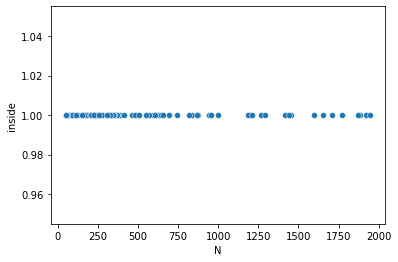

In [111]:
import seaborn as sns
sns.scatterplot(data = res_df.groupby('S').mean(), x='N', y = 'inside')

In [112]:
res = []
for S in range(n_sim):
    N = int(loguniform.rvs(50, 2000, size=1)[0])
    seq_len = loguniform.rvs(1e7, 5e8, size=1)[0]
    ts = sim(pop_ind=N, split_time=split_time, seq_len=seq_len, rec_rate=rec_rate, mut_rate=mut_rate, 
         seed=None, ancestral_size=None)
    true_fst = get_obs_fst(ts, n_block=1)[0]
    for B in range(n_obs):
        n_block = int(np.ceil((seq_len/1e6)))
        obs_ts = observe(ts=ts, num_ind=n_ind_obs, max_sites=max_sites, num_pop=2)
        obs_ts = obs_ts.simplify()
        obs_sites = obs_ts.num_sites
        obs_fst, jk_vals, sizes = get_obs_fst(obs_ts, n_block=n_block)
        lower, upper = jk_delete_mj(params=(jk_vals, sizes), confidence=confidence, obs_value=obs_fst)
        inside = lower < obs_fst < upper
        res.append(RES(N, max_sites, obs_sites, n_ind_obs, seq_len, n_block, S, B,
                                     true_fst, obs_fst, lower, upper, inside))

sum([x[-1] for x in res ]) / (n_sim*n_obs)

1.0